# Segmenting and Clustering Similar Towns in Massachusetts Based on Venues

Import the necessary libraries

In [1]:
import pandas as pd
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  

     |████████████████████████████████| 79 kB 5.4 MB/s eta 0:00:011
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=c5280442a35586022308db4ca256cf2e80450e4741bc25b80cd016ca7d02b351
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


In [2]:
url_towns='https://en.wikipedia.org/wiki/List_of_Massachusetts_locations_by_per_capita_income'
list_towns=pd.read_html(url_towns)[2]
list_towns

,Rank,Municipality,Type,County,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,Weston,Town,Middlesex,"$105,217","$192,563","$250,000+",11538,3769
1,2.0,Dover,Town,Norfolk,"$89,476","$187,829","$193,750",5677,1891
2,3.0,Carlisle,Town,Middlesex,"$77,585","$160,034","$175,833",4918,1745
3,4.0,Sherborn,Town,Middlesex,"$73,420","$223,444","$164,063",4169,1427
4,5.0,Sudbury,Town,Middlesex,"$72,744","$170,924","$186,507",17922,5783
...,...,...,...,...,...,...,...,...,...
348,347.0,Chelsea,City,Suffolk,"$20,617","$47,291","$48,849",36222,11550
349,348.0,Holyoke,City,Hampden,"$19,968","$31,628","$37,299",40029,15846
350,349.0,Amherst,Town,Hampshire,"$19,796","$53,191","$96,733",38651,8583
351,350.0,Springfield,City,Hampden,"$18,133","$34,311","$39,535",153428,55894


In [3]:
df = list_towns.dropna() #note two rows are removed
df

,Rank,Municipality,Type,County,Per capitaincome,Medianhouseholdincome,Medianfamilyincome,Population,Number ofhouseholds
0,1.0,Weston,Town,Middlesex,"$105,217","$192,563","$250,000+",11538,3769
1,2.0,Dover,Town,Norfolk,"$89,476","$187,829","$193,750",5677,1891
2,3.0,Carlisle,Town,Middlesex,"$77,585","$160,034","$175,833",4918,1745
3,4.0,Sherborn,Town,Middlesex,"$73,420","$223,444","$164,063",4169,1427
4,5.0,Sudbury,Town,Middlesex,"$72,744","$170,924","$186,507",17922,5783
...,...,...,...,...,...,...,...,...,...
348,347.0,Chelsea,City,Suffolk,"$20,617","$47,291","$48,849",36222,11550
349,348.0,Holyoke,City,Hampden,"$19,968","$31,628","$37,299",40029,15846
350,349.0,Amherst,Town,Hampshire,"$19,796","$53,191","$96,733",38651,8583
351,350.0,Springfield,City,Hampden,"$18,133","$34,311","$39,535",153428,55894


Create a dataframe with only the needed column of Municipality.

In [4]:
df = df.drop(['Rank','Type','County','Per capitaincome','Medianhouseholdincome','Medianfamilyincome','Population','Number ofhouseholds'],axis=1)
df.columns = ["Neighborhood"]
df

,Neighborhood
0,Weston
1,Dover
2,Carlisle
3,Sherborn
4,Sudbury
...,...
348,Chelsea
349,Holyoke
350,Amherst
351,Springfield


Create a new dataframe consisting of Towns.

In [5]:
df.shape

(351, 1)

Find the latitude and longitude coordinates for each town.

In [6]:
geolocator = Nominatim(user_agent="my_user_agent")

list_latitude = []
list_longitude = []

for town in df["Neighborhood"]:
    town = town
    state = "Massachusetts"
    loc = geolocator.geocode(town+','+ state)
    list_latitude.append(loc.latitude)
    list_longitude.append(loc.longitude)

Add the latitude and longitude to the dataframe.

In [7]:
df['Latitude']=list_latitude
df['Longitude']=list_longitude
df

,Neighborhood,Latitude,Longitude
0,Weston,42.366763,-71.303113
1,Dover,42.245931,-71.282834
2,Carlisle,42.529260,-71.349505
3,Sherborn,42.238986,-71.369781
4,Sudbury,42.383428,-71.416173
...,...,...,...
348,Chelsea,42.391764,-71.032828
349,Holyoke,42.207143,-72.607650
350,Amherst,42.368566,-72.505714
351,Springfield,42.101876,-72.588673


## Clustering
Import libraries to be used in this section.

Add credentials to access Foursquare API.

In [8]:
CLIENT_ID = '5U55WV25CDHHNVKBDJBW1TD4NR44PXRH4ESANGDKTCU4THCA' # your Foursquare ID
CLIENT_SECRET = 'PTQDS24PHK2HOTJHAVF2UE2PIG3VFENQSTNNJ1OTGTNIHYAX' # your Foursquare Secret
ACCESS_TOKEN = 'OG1S1OK2WI2UWXMSXDOPIQVHMMCLZIWQFILGHDGVAN3HRGOD' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5U55WV25CDHHNVKBDJBW1TD4NR44PXRH4ESANGDKTCU4THCA
CLIENT_SECRET:PTQDS24PHK2HOTJHAVF2UE2PIG3VFENQSTNNJ1OTGTNIHYAX


Get the latitude and longitude of Massachusetts.

In [9]:
address = "Massachusetts"

geolocator = Nominatim(user_agent="massachusetts_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Massachusetts are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Massachusetts are 42.3788774, -72.032366.


In [10]:
df['State'] = 'Massachusetts'

Use the coordinates to create a map of Massachusetts with markers for each county.

In [11]:
map_MA = folium.Map(location=[latitude, longitude], zoom_start=8)
map_MA

for lat, lng, town, state in zip(
        df['Latitude'], 
        df['Longitude'],
        df['Neighborhood'],
        df['State']):
    label = '{}, {}'.format(town, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_MA)  

map_MA

Create the URL to access the venues within a 500 meter radius from the Parkwoods.

Create a function to explore venues in all the neighborhoods in Toronto.

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the neighborhoods from the function created above and create a dataframe with it.

In [13]:
town_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Weston
Dover
Carlisle
Sherborn
Sudbury
Wellesley
Winchester
Manchester-by-the-Sea
Lexington
Boxford
Wayland
Concord
Brookline
Norwell
Newton
Needham
Westwood
Southborough
Medfield
Lincoln
Boxborough
Cohasset
Hingham
Marblehead
Hopkinton
Belmont
Topsfield
Bolton
Alford
Duxbury
Longmeadow
Acton
Boylston
Sharon
Richmond
West Newbury
Stow
Andover
Harvard
Pelham
Tyringham
Holliston
Arlington
Westford
Mount Washington
Scituate
Chelmsford
Swampscott
Groton
Dunstable
Littleton
Cambridge
Nantucket
Reading
North Andover
Lynnfield
Wenham
Natick
Milton
Newburyport
Canton
Westborough
Ashland
Nahant
Marion
Provincetown
Chatham
North Reading
Wrentham
Watertown
Hamilton
Berlin
Chilmark
Northborough
Medway
Georgetown
Marshfield
Norfolk
Dedham
Ipswich
Princeton
Walpole
Foxborough
Upton
Bedford
Melrose
Sutton
Essex
Mansfield
Franklin
Newbury
Rockport
Mendon
Orleans
Hanover
Burlington
Hull
Tyngsborough
Holden
Sterling
Leverett
Egremont
Groveland
Wakefield
Shrewsbury
Grafton
Tolland
Tewksbury
Millis
Falmou

In [14]:
town_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Weston,42.366763,-71.303113,Dumpling Daughter,42.366820,-71.300544,Peking Duck Restaurant
1,Weston,42.366763,-71.303113,Theo's Pizzeria & Grille,42.367089,-71.301650,Pizza Place
2,Weston,42.366763,-71.303113,Brothers Marketplace,42.366831,-71.300548,Market
3,Weston,42.366763,-71.303113,bruegger's Weston,42.366701,-71.300848,Bagel Shop
4,Weston,42.366763,-71.303113,Ye Olde Cottage Restaurant,42.367537,-71.300832,Diner


Find the number of venues returned by each neighborhood.

In [15]:
town_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abington,9,9,9,9,9,9
Acton,4,4,4,4,4,4
Acushnet,7,7,7,7,7,7
Adams,14,14,14,14,14,14
Alford,1,1,1,1,1,1
...,...,...,...,...,...,...
Winthrop,15,15,15,15,15,15
Woburn,26,26,26,26,26,26
Worcester,8,8,8,8,8,8


In [16]:
print('There are {} uniques categories.'.format(len(town_venues['Venue Category'].unique())))

There are 299 uniques categories.


Create a dataframe with dummy variables denoting types of venues in each county.

In [17]:
# one hot encoding
town_onehot = pd.get_dummies(town_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
town_onehot['Neighborhood'] = town_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [town_onehot.columns[-1]] + list(town_onehot.columns[:-1])
town_onehot = town_onehot[fixed_columns]

town_onehot.head()

,Yoga Studio,ATM,Accessories Store,Acupuncturist,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
town_onehot.shape

(3141, 299)

Find the average of the frequency of occurrence in each category by grouping by the town.

In [19]:
town_grouped = town_onehot.groupby('Neighborhood').mean().reset_index()
town_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Acupuncturist,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Abington,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Acushnet,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Adams,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Alford,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
town_grouped.shape

(257, 299)

Find the top 5 most common venues.

In [21]:
num_top_venues = 5

for hood in town_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = town_grouped[town_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abington----
                venue  freq
0      Sandwich Place  0.11
1         Video Store  0.11
2  Chinese Restaurant  0.11
3        Liquor Store  0.11
4         Coffee Shop  0.11


----Acton----
           venue  freq
0          Trail  0.25
1     Playground  0.25
2    Pizza Place  0.25
3  Historic Site  0.25
4    Yoga Studio  0.00


----Acushnet----
                 venue  freq
0  American Restaurant  0.29
1          Post Office  0.14
2    Convenience Store  0.14
3           Steakhouse  0.14
4                Diner  0.14


----Adams----
                        venue  freq
0                 Pizza Place  0.14
1                         Bar  0.14
2  Tourist Information Center  0.07
3         Martial Arts School  0.07
4                        Food  0.07


----Alford----
                  venue  freq
0           IT Services   1.0
1           Yoga Studio   0.0
2            Nail Salon   0.0
3     Other Repair Shop   0.0
4  Other Great Outdoors   0.0


----Amesbury----
                 ven

Sort the venues in descending occurence order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Find the 10 most common venues for each town.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = town_grouped['Neighborhood']

for ind in np.arange(town_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(town_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abington,Convenience Store,American Restaurant,Coffee Shop,Chinese Restaurant,Sandwich Place,Brewery,Liquor Store,Pizza Place,Video Store,Home Service
1,Acton,Historic Site,Playground,Pizza Place,Trail,Farmers Market,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
2,Acushnet,American Restaurant,Convenience Store,Diner,Post Office,Donut Shop,Steakhouse,Exhibit,Eye Doctor,Fair,Farm
3,Adams,Pizza Place,Bar,Park,Sandwich Place,Liquor Store,Chinese Restaurant,Martial Arts School,Tourist Information Center,Electronics Store,Pharmacy
4,Alford,IT Services,Women's Store,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm,Farmers Market


Find the optimal number of clusters using the elbow method.

In [24]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

town_grouped_clustering = town_grouped.drop('Neighborhood', 1)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(town_grouped_clustering) 
    kmeanModel.fit(town_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(town_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / town_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(town_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / town_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

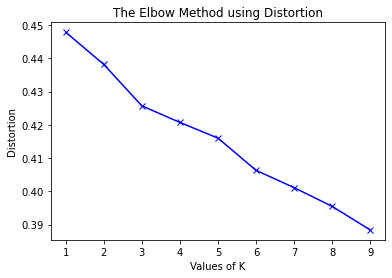

In [25]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

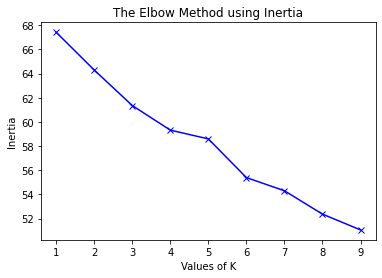

In [26]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Run k-means to cluster the neighborhood into 5 clusters.

In [27]:
# set number of clusters
kclusters = 6

town_grouped_clustering = town_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(town_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 4, 4, 4, 4, 4, 4, 4, 5], dtype=int32)

Create a dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
df_town = df[['Neighborhood','Latitude','Longitude']]
df_town

,Neighborhood,Latitude,Longitude
0,Weston,42.366763,-71.303113
1,Dover,42.245931,-71.282834
2,Carlisle,42.529260,-71.349505
3,Sherborn,42.238986,-71.369781
4,Sudbury,42.383428,-71.416173
...,...,...,...
348,Chelsea,42.391764,-71.032828
349,Holyoke,42.207143,-72.607650
350,Amherst,42.368566,-72.505714
351,Springfield,42.101876,-72.588673


In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_MA = df_town
df_MA.columns = ['Neighborhood','Latitude','Longitude']

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_MA = df_MA.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_MA.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Weston,42.366763,-71.303113,4.0,Bagel Shop,Coffee Shop,Grocery Store,Market,Diner,Peking Duck Restaurant,Pharmacy,Pizza Place,Fish Market,Fish & Chips Shop
1,Dover,42.245931,-71.282834,4.0,Grocery Store,Post Office,Donut Shop,Deli / Bodega,Farm,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
2,Carlisle,42.529260,-71.349505,4.0,Playground,Sandwich Place,Women's Store,Farmers Market,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm
3,Sherborn,42.238986,-71.369781,3.0,Food,Convenience Store,Sandwich Place,Pizza Place,Donut Shop,Farm,Event Service,Event Space,Exhibit,Eye Doctor
4,Sudbury,42.383428,-71.416173,3.0,Mediterranean Restaurant,Donut Shop,Pizza Place,Italian Restaurant,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Fair,Farm


Convert column 'Cluster Lables' to an integer type to be used to make a map.

In [30]:
df_map_MA = df_MA
df_map_MA['Cluster Labels'] = df_map_MA['Cluster Labels'].fillna(0.0).astype(int)
df_map_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 352
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            351 non-null    object 
 1   Latitude                351 non-null    float64
 2   Longitude               351 non-null    float64
 3   Cluster Labels          351 non-null    int64  
 4   1st Most Common Venue   257 non-null    object 
 5   2nd Most Common Venue   257 non-null    object 
 6   3rd Most Common Venue   257 non-null    object 
 7   4th Most Common Venue   257 non-null    object 
 8   5th Most Common Venue   257 non-null    object 
 9   6th Most Common Venue   257 non-null    object 
 10  7th Most Common Venue   257 non-null    object 
 11  8th Most Common Venue   257 non-null    object 
 12  9th Most Common Venue   257 non-null    object 
 13  10th Most Common Venue  257 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory

Create a map of the clusters. 

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_MA['Latitude'], df_MA['Longitude'], df_MA['Neighborhood'], df_MA['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1
Examine cluster 1.

In [32]:
df_MA.loc[df_MA['Cluster Labels'] == 0, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Boylston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Pelham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,Tyringham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,Mount Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,Dunstable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
334,Rowe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,Monroe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,Athol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
346,Orange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cluster 2
Examine cluster 2.

In [39]:
x = df_MA.loc[df_MA['Cluster Labels'] == 1, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]
x

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Bolton,Park,Women's Store,Farmers Market,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm,Fast Food Restaurant
36,Stow,Pizza Place,American Restaurant,Park,Women's Store,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Fair,Farm
53,Reading,Pool,Playground,Park,Farm,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fair
90,Newbury,Butcher,Park,Home Service,Women's Store,Farm,Event Service,Event Space,Exhibit,Eye Doctor,Fair
95,Burlington,Park,Gas Station,Department Store,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Fair,Farm,Farmers Market
159,Hampden,Post Office,Park,Italian Restaurant,Women's Store,Farmers Market,Event Service,Event Space,Exhibit,Eye Doctor,Fair
165,Charlton,Park,Women's Store,Farmers Market,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm,Fast Food Restaurant
189,Townsend,Golf Course,Women's Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fair,Farm,Farmers Market,Fast Food Restaurant
209,Bourne,Bar,Post Office,Pharmacy,Park,Farm,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
225,Swansea,Dessert Shop,Park,Gift Shop,Farmers Market,Event Space,Exhibit,Eye Doctor,Fair,Farm,Women's Store


### Cluster 3
Examine cluster 3.

In [34]:
df_MA.loc[df_MA['Cluster Labels'] == 2, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
213,Hubbardston,Construction & Landscaping,Women's Store,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm,Farmers Market
300,Dudley,Construction & Landscaping,Women's Store,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm,Farmers Market
343,Southbridge,Construction & Landscaping,Women's Store,Fast Food Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm,Farmers Market


### Cluster 4
Examine cluster 4.

In [35]:
df_MA.loc[df_MA['Cluster Labels'] == 3, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Sherborn,Food,Convenience Store,Sandwich Place,Pizza Place,Donut Shop,Farm,Event Service,Event Space,Exhibit,Eye Doctor
4,Sudbury,Mediterranean Restaurant,Donut Shop,Pizza Place,Italian Restaurant,Fast Food Restaurant,Event Space,Exhibit,Eye Doctor,Fair,Farm
17,Southborough,Convenience Store,Lawyer,Pizza Place,Pharmacy,Print Shop,Breakfast Spot,Golf Course,Baseball Field,Spa,Historic Site
26,Topsfield,Lawyer,Pizza Place,Hardware Store,Deli / Bodega,Bank,Convenience Store,Fishing Store,Farm,Ethiopian Restaurant,Event Service
31,Acton,Historic Site,Playground,Pizza Place,Trail,Farmers Market,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
58,Milton,Convenience Store,Home Service,Construction & Landscaping,Park,Women's Store,Farmers Market,Event Service,Event Space,Exhibit,Eye Doctor
68,Wrentham,Gastropub,Convenience Store,Breakfast Spot,Donut Shop,Bank,Fast Food Restaurant,Exhibit,Eye Doctor,Fair,Farm
74,Medway,Playground,Convenience Store,Pizza Place,Nightclub,Business Service,Women's Store,Farm,Event Space,Exhibit,Eye Doctor
75,Georgetown,Pizza Place,Sandwich Place,Baseball Field,Pharmacy,Grocery Store,American Restaurant,Bank,Bagel Shop,Donut Shop,Fair
83,Upton,Food,Pizza Place,Business Service,Martial Arts School,Restaurant,Fair,Event Service,Event Space,Exhibit,Eye Doctor


### Cluster 5
Examine cluster 5.

In [36]:
df_MA.loc[df_MA['Cluster Labels'] == 4, df_MA.columns[[0] + list(range(4, df_MA.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Weston,Bagel Shop,Coffee Shop,Grocery Store,Market,Diner,Peking Duck Restaurant,Pharmacy,Pizza Place,Fish Market,Fish & Chips Shop
1,Dover,Grocery Store,Post Office,Donut Shop,Deli / Bodega,Farm,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
2,Carlisle,Playground,Sandwich Place,Women's Store,Farmers Market,Event Service,Event Space,Exhibit,Eye Doctor,Fair,Farm
5,Wellesley,Pizza Place,Clothing Store,Coffee Shop,Arts & Crafts Store,Thai Restaurant,Mediterranean Restaurant,Italian Restaurant,Spa,Restaurant,Fast Food Restaurant
6,Winchester,New American Restaurant,Italian Restaurant,Coffee Shop,Plaza,Jewelry Store,Soccer Field,Farmers Market,Fair,Spa,Café
...,...,...,...,...,...,...,...,...,...,...,...
347,New Bedford,Gym,Breakfast Spot,Fast Food Restaurant,Burger Joint,Botanical Garden,Flower Shop,Flea Market,Fishing Store,Fishing Spot,Fish Market
348,Chelsea,Plaza,Dessert Shop,Mexican Restaurant,Fast Food Restaurant,Electronics Store,Bank,Donut Shop,Thai Restaurant,Grocery Store,Discount Store
349,Holyoke,Pizza Place,Spanish Restaurant,Bar,Bakery,Science Museum,Storage Facility,Trail,Art Gallery,Fast Food Restaurant,American Restaurant
351,Springfield,Hotel,Hockey Arena,Shipping Store,American Restaurant,Donut Shop,Café,Cocktail Bar,BBQ Joint,Casino,Strip Club
